<h1>
    <center>
        Processing Images with OpenCV

In this notebook the topics presented are:
* Converting images between differente color models
* Understanding the importance of frequencies and the Fourier transform in image processing
* Applying high-pass filters (HPFs), low-pass filters (LPFs), edge detection filters, and custom convolution filters
* Detecting and analyzing contours, lines, circles, and other geometric shapes
* Writing classes and functions that encapsulate the implementation of a filter

# Converting images between different color models

Open CV implements literally hundreds of formulas related to the conversion of color models. From these hundreds of templates, we will use four types of color templates: grayscale, BGR, RGB and hue saturation value (HSV).

* **Grayscale**: is a model that reduces color information by translating it into shades of gray or brightness
* **BGR**: is the blue-green-red color model, in which each pixel has a triplet of values representing the blue, green, and red components or channels of the pixel's color.
* **RGB**: is the red-green-blue color model, in which each pixel has a triplet of values representing the blue, green, and red components or channels of the pixel's color.
* **HSV**: model uses a different triplet of channels. Hue is the color's tone,  saturation is its intensity, and value represents its brightness.

# Light is not paint

* Paint is subtratctive
* Light is additive

# HPF

An HPF is a filter that examines a region of an image and boosts the intensity of certain pixels based on the difference in the intensity of the surrounding pixels. This kernel is applied in edge detection.

Take, for example, the following kernel:

\begin{equation}
\left[\begin{matrix}
0&-0.25 & 0 \\
-0.25& 1 & -0.25 \\
0 & -0.25 & 0
\end{matrix}\right]
\end{equation}

In [7]:
import cv2
import numpy as np
from scipy import ndimage

kernel_3x3 = np.array([[-1, -1, -1],
                       [-1,  8, -1],
                       [-1, -1, -1]])

kernel_5x5 = np.array([[-1, -1, -1, -1, -1],
                       [-1,  1,  2,  1, -1],
                       [-1,  2,  4,  2, -1],
                       [-1,  1,  2,  1, -1],
                       [-1, -1, -1, -1, -1]])

img = cv2.imread("./mr incredible.jpg", 0)

k3 = ndimage.convolve(img, kernel_3x3)
k5 = ndimage.convolve(img, kernel_5x5)

blurred = cv2.GaussianBlur(img, (17,17), 0) # Filtro gaussiano utilizado para suavizar a imagem
g_hpf = img - blurred

cv2.imshow("3x3", k3)
cv2.imshow("5x5", k5)
cv2.imshow("blurred", blurred)
cv2.imshow("g_hpf", g_hpf)
cv2.waitKey()
cv2.destroyAllWindows()

# Creating modules

In this notebook we will create a new module to add a filter to the cameo application. Let's create a file called `filters.py` in the same directory as `cameo.py`. We need the following import statements in filters.py:
```Python
import cv2
import numpy
import utils
```

Let's also create a file called `utils.py` in the same directory. It should contain the following import statements:
```Python
import cv2
import numpy
import scipy.interpolate
```

We will be adding filter functions and classes to `filters.py`, while more general-purpose math functions will go in `utils.py`.

# Edge detection

The OpenCV provides many edge-finding filters, including `Laplacian`, `Sobel`, and `Scharr`. However, these filters are sensitive to noise. Then blur filters can be used to reduce this noise.

The OpenCV has blurring filter as`blur`, `medianBlur`, and `GaussianBlur`. The arguments for the edge-finding and blurring filters vary but always include ksize, an odd whole number that represents the width and height (in pixels) of a filter's kernel.

From edge detection:
1. The medianBlur is utilized
2. The BGR image is converted for grayscale image
3. The grayscale image normalized
4. The Laplacian filter is applied
5. The inverse normalization is applied

The implementation on `filters.py`

```Python
def strokeEdges(src, dst, blurKsize=7, edgeKsize=5):
    if blurKsize >= 3:
        blurredSrc = cv2.medianBlur(src, blurKsize)
        graySrc = cv2.cvtColor(blurredSrc, cv2.COLOR_BGR2GRAY)
    else:
        graySrc = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    cv2.Laplacian(graySrc, cv2.CV_8U, graySrc, ksize = edgeKsize)
    normalizedInverseAlpha = (1.0 / 255) * (255 - graySrc) # Utilized for multiply it with the source image to darken the edges
    channels = cv2.split(src)
    for channel in channels:
        channel[:] = channel * normalizedInverseAlpha
    cv2.merge(channels, dst)

```

# Custom kernels – getting convoluted

As we have just seen, many of OpenCV's predefined filters use a kernel. Remember that a kernel is a set of weights that determines how each output pixel is calculated from a neighborhood of input pixels. Another term for a kernel is a convolution matrix. It mixes up or convolves the pixels in a region. Similarly, a kernel-based filter may be called a convolution filter.

OpenCV provides a very versatile `filter2D()` function, which applies any kernel or convolution matrix that we specify.


In our application we can implement  one class, `VConvolutionFilter`, will represent a convolution filter in general. A subclass, `SharpenFilter`, will represent our sharpening filter specifically. Let's edit filters.py so that we can implement these two new classes, as follows:

```Python

class VConvolutionFilter(object):
    """A filter that applies a convolution to V (or all of BGR)."""

    def __init__(self, kernel):
        self._kernel = kernel

    def apply(self, src, dst):
        """Apply the filter with a BGR or gray source/destination."""
        cv2.filter2D(src, -1, self._kernel, dst)

class SharpenFilter(VConvolutionFilter):
    """A sharpen filter with a 1-pixel radius."""

    def __init__(self):
        kernel = numpy.array([[-1, -1, -1],
                              [-1,  9, -1],
                              [-1, -1, -1]])
        VConvolutionFilter.__init__(self, kernel)
```

Edge detection filter to `filters.py`
```Python
class FindEdgesFilter(VConvolutionFilter):
    """An edge-finding filter with a 1-pixel radius."""

    def __init__(self):
        kernel = numpy.array([[-1, -1, -1],
                              [-1,  8, -1],
                              [-1, -1, -1]])
        VConvolutionFilter.__init__(self, kernel)
```

Blur filter to `filters.py`
```Python
class BlurFilter(VConvolutionFilter):
    """A blur filter with a 2-pixel radius."""

    def __init__(self):
        kernel = numpy.array([[0.04, 0.04, 0.04, 0.04, 0.04],
                              [0.04, 0.04, 0.04, 0.04, 0.04],
                              [0.04, 0.04, 0.04, 0.04, 0.04],
                              [0.04, 0.04, 0.04, 0.04, 0.04],
                              [0.04, 0.04, 0.04, 0.04, 0.04]])
        VConvolutionFilter.__init__(self, kernel)

```

Our sharpening, edge detection, and blur filters use kernels that are highly symmetric. Sometimes, though, kernels with less symmetry produce an interesting effect. Let's consider a kernel that blurs on one side (with positive weights) and sharpens on the other (with negative weights). It will produce a ridged or embossed effect. Here is an implementation that we can add to `filters.py`:

```Python
class EmbossFilter(VConvolutionFilter):
    """An emboss filter with a 1-pixel radius."""

    def __init__(self):
        kernel = numpy.array([[-2, -1, 0],
                              [-1,  1, 1],
                              [ 0,  1, 2]])
        VConvolutionFilter.__init__(self, kernel)
```

# Modifying the application

Now that we have high-level functions and classes for several filters, it is trivial to apply any of them to the captured frames in Cameo. Let's edit cameo.py and add the lines that appear in bold in the following excerpts. First, we need to add our filters module to our list of imports, as follows:
```Python
import cv2
import filters
from managers import WindowManager, CaptureManager
```

We need to modify the run method in order to apply our choice of filters. Refer to
the following example:
```Python
def run(self):
        """Run the main loop."""
        self._windowManager.createWindow()
        while self._windowManager.isWindowCreated:
            self._captureManager.enterFrame()
            frame = self._captureManager.frame

            if frame is not None:
                filters.strokeEdges(frame, frame)

            self._captureManager.exitFrame()
            self._windowManager.processEvents()
```

# Implemented Class

In [8]:
import cameo

c = cameo.Cameo()
c.run()

# Edge detection with Canny

OpenCV offers a handy function called Canny (after the algorithm's inventor, John F.
Canny), which is very popular not only because of its effectiveness, but also because of the
simplicity of its implementation in an OpenCV program since it is a one-liner. Add the class `CannyFilter` in `filters.py`:
```Python
class CannyFilter():
    def apply(self, src, dst):
        """Apply the filter with Canny filter."""
        channels = cv2.split(src)
        canny = cv2.Canny(src, 75, 200)
        for channel in channels:
        	channel[:] = canny
        cv2.merge(channels,dst)
```

Add the atribute `self.filter` and method `run_filter` for test of filters.
* Atribute
```Python
    def __init__(self):
        self._windowManager = WindowManager('Cameo',
                                            self.onKeypress)
        self._captureManager = CaptureManager(
            cv2.VideoCapture(0), self._windowManager, True)
        self.filter = filters.CannyFilter()
```
* method

```Python
    def run_filter(self):
        """Run the main loop."""
        self._windowManager.createWindow()
        while self._windowManager.isWindowCreated:
            self._captureManager.enterFrame()
            frame = self._captureManager.frame

            if frame is not None:
                self.filter.apply(frame, frame)

            self._captureManager.exitFrame()
            self._windowManager.processEvents()
```

# Test Canny

## Import

In [9]:
import cameo
from filters import BlurFilter

c1 = cameo.Cameo()
c1.filter = BlurFilter()
c1.run_filter()

# Test all filters

## SharpenFilter

Sharpen filter in image processing improves spatial resolution by enhancing object boundaries but at the cost of image noise:
*        i) Highlight fine detail.
*        ii) Enhance detail that has been blurred.
```Python
class SharpenFilter(VConvolutionFilter):
    """A sharpen filter with a 1-pixel radius."""

    def __init__(self):
        kernel = numpy.array([[-1, -1, -1],
                              [-1,  9, -1],
                              [-1, -1, -1]])
        VConvolutionFilter.__init__(self, kernel)
```

In [10]:
from filters import SharpenFilter

c1 = cameo.Cameo()
c1.filter = SharpenFilter()
c1.run()

## FindEdgesFilter

Accentuates the borders of the image
```Python
class FindEdgesFilter(VConvolutionFilter):
    """An edge-finding filter with a 1-pixel radius."""

    def __init__(self):
        kernel = numpy.array([[-1, -1, -1],
                              [-1,  8, -1],
                              [-1, -1, -1]])
        VConvolutionFilter.__init__(self, kernel)
```

In [11]:
from filters import FindEdgesFilter

c1 = cameo.Cameo()
c1.filter = FindEdgesFilter()
c1.run()

## BlurFilter

Image processing, a Gaussian blur (also known as Gaussian smoothing) is the result of blurring an image by a Gaussian function (named after mathematician and scientist Carl Friedrich Gauss). 
```Python
    """A blur filter with a 2-pixel radius."""

    def __init__(self):
        kernel = numpy.array([[0.04, 0.04, 0.04, 0.04, 0.04],
                              [0.04, 0.04, 0.04, 0.04, 0.04],
                              [0.04, 0.04, 0.04, 0.04, 0.04],
                              [0.04, 0.04, 0.04, 0.04, 0.04],
                              [0.04, 0.04, 0.04, 0.04, 0.04]])
        VConvolutionFilter.__init__(self, kernel)
```

In [12]:
from filters import BlurFilter

c1 = cameo.Cameo()
c1.filter = BlurFilter()
c1.run_filter()

## EmbossFilter

This filter stamps and carves the active layer or selection, giving it relief with bumps and hollows. Bright areas are raised and dark ones are carved. You can vary the lighting. 
```Python
class EmbossFilter(VConvolutionFilter):
    """An emboss filter with a 1-pixel radius."""

    def __init__(self):
        kernel = numpy.array([[-2, -1, 0],
                              [-1,  1, 1],
                              [ 0,  1, 2]])
        VConvolutionFilter.__init__(self, kernel)
```

In [13]:
from filters import EmbossFilter

c1 = cameo.Cameo()
c1.filter = EmbossFilter()
c1.run()

# Contour detection

A vital task in computer vision is contour detection. We want to detect contours or outlines of subjects contained in an image or video frame, not only as an end in itself but also as a step toward other operations. These operations are, namely, computing bounding polygons, approximating shapes, and generally calculating regions of interest (ROIs). Example of ROI.
```Python
import cv2
import numpy as np

img = np.zeros((200, 200), dtype=np.uint8)
img[50:150, 50:150] = 255

ret, thresh = cv2.threshold(img, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,
                                       cv2.CHAIN_APPROX_SIMPLE)
color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
img = cv2.drawContours(color, contours, -1, (0,255,0), 2)
cv2.imshow("contours", color)
cv2.waitKey()
cv2.destroyAllWindows()
```

In [14]:
import cv2
import numpy as np

img = np.zeros((200, 200), dtype=np.uint8)
img[50:150, 50:150] = 255

ret, thresh = cv2.threshold(img, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,
                                       cv2.CHAIN_APPROX_SIMPLE)
color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
img = cv2.drawContours(color, contours, -1, (0,255,0), 2)
cv2.imshow("contours", color)
cv2.waitKey()
cv2.destroyAllWindows()

# Bounding boc, minimu area rectangle, and minimum enclosing circle

Finding the contours of a square is a simple task; irregular, skewed, and rotated shapes bring out the full potential of OpenCV's cv2.findContours function. Let's take a look at the following image:

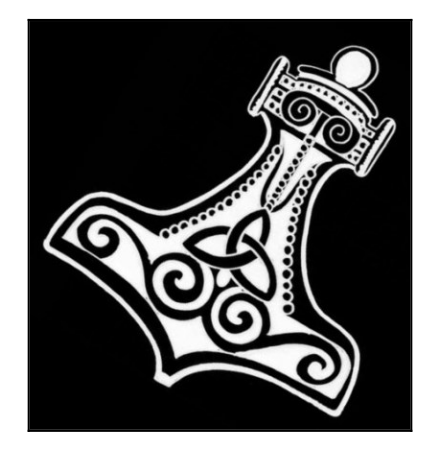

First, the following code reads an image from a file, converts it
into grayscale, applies a threshold to the grayscale image, and finds the contours in the
thresholded image:

```Python
import cv2
import numpy as np

OPENCV_MAJOR_VERSION = int(cv2.__version__.split('.')[0])

img = cv2.pyrDown(cv2.imread("hammer.jpg", cv2.IMREAD_UNCHANGED))

ret, thresh = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
                            127, 255, cv2.THRESH_BINARY)

if OPENCV_MAJOR_VERSION >= 4:
    # OpenCV 4 or a later version is being used.
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL,
                                      cv2.CHAIN_APPROX_SIMPLE)
else:
    # OpenCV 3 or an earlier version is being used.
    # cv2.findContours has an extra return value.
    # The extra return value is the thresholded image, which is
    # unchanged, so we can ignore it.
    _, contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL,
                                         cv2.CHAIN_APPROX_SIMPLE)
```

In [15]:
import cv2
import numpy as np

OPENCV_MAJOR_VERSION = int(cv2.__version__.split('.')[0])

img = cv2.pyrDown(cv2.imread("./pingu.png", cv2.IMREAD_UNCHANGED))

ret, thresh = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
                            127, 255, cv2.THRESH_BINARY)

if OPENCV_MAJOR_VERSION >= 4:
    # OpenCV 4 or a later version is being used.
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL,
                                      cv2.CHAIN_APPROX_SIMPLE)
else:
    # OpenCV 3 or an earlier version is being used.
    # cv2.findContours has an extra return value.
    # The extra return value is the thresholded image, which is
    # unchanged, so we can ignore it.
    _, contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL,
                                         cv2.CHAIN_APPROX_SIMPLE)

Now, for each contour, we can find and draw the bounding box, the minimum enclosing
rectangle, and the minimum enclosing circle, as shown in the following code:
```Python
for c in contours:
    # find bounding box coordinates
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)

    # find minimum area
    rect = cv2.minAreaRect(c)
    # calculate coordinates of the minimum area rectangle
    box = cv2.boxPoints(rect)
    # normalize coordinates to integers
    box = np.int0(box)
    # draw contours
    cv2.drawContours(img, [box], 0, (0,0, 255), 3)

    # calculate center and radius of minimum enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(c)
    # cast to integers
    center = (int(x), int(y))
    radius = int(radius)
    # draw the circle
    img = cv2.circle(img, center, radius, (0, 255, 0), 2)
```

In [16]:
for c in contours:
    # find bounding box coordinates
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)

    # find minimum area
    rect = cv2.minAreaRect(c)
    # calculate coordinates of the minimum area rectangle
    box = cv2.boxPoints(rect)
    # normalize coordinates to integers
    box = np.int0(box)
    # draw contours
    cv2.drawContours(img, [box], 0, (0,0, 255), 3)

    # calculate center and radius of minimum enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(c)
    # cast to integers
    center = (int(x), int(y))
    radius = int(radius)
    # draw the circle
    img = cv2.circle(img, center, radius, (0, 255, 0), 2)

Finally, we can use the following code to draw the contours and show the image in a window until the user presses a key:

```Python
cv2.drawContours(img, contours, -1, (255, 0, 0), 1)
cv2.imshow("contours", img)

cv2.waitKey()
cv2.destroyAllWindows()
```

In [23]:
cv2.drawContours(img, contours, -1, (255, 0, 0), 1)
cv2.imshow("contours", img)

cv2.waitKey()
cv2.destroyAllWindows()

# Convex contours and the Douglas-Peucker algorithm

When working with contours, we may encounter subjects with diverse shapes, including
convex ones. A convex shape is one where there are no two points within this shape whose
connecting line goes outside the perimeter of the shape itself.
The first facility that OpenCV offers to calculate the approximate bounding polygon of a
shape is cv2.approxPolyDP. This function takes three parameters:

* A contour.
* An epsilon value representing the maximum discrepancy between the original contour and the approximated polygon (the lower the value, the closer the approximated value will be to the original contour).
* A Boolean flag. If it is True, it signifies that the polygon is closed.

Now that we know what an epsilon is, we need to obtain contour perimeter information as
a reference value. This can be obtained with the `cv2.arcLength` function of OpenCV:

```Python
epsilon = 0.01 * cv2.arcLength(cnt, True)
approx = cv2.approxPolyDP(cnt, epsilon, True)
```

OpenCV also offers a `cv2.convexHull` function for obtaining processed contour
information for convex shapes. This is a straightforward one-line expression:

```Python
hull = cv2.convexHull(cnt)
```

Let's combine the original contour, approximated polygon contour, and the convex hull
into one image to observe the differences between them. To simplify things, we will draw
the contours on top of a black background so that the original subject is not visible but its contours are:

```Python
import cv2
import numpy as np

OPENCV_MAJOR_VERSION = int(cv2.__version__.split('.')[0])

img = cv2.pyrDown(cv2.imread("hammer.jpg", cv2.IMREAD_UNCHANGED))

ret, thresh = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
                            127, 255, cv2.THRESH_BINARY)

if OPENCV_MAJOR_VERSION >= 4:
    # OpenCV 4 or a later version is being used.
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL,
                                      cv2.CHAIN_APPROX_SIMPLE)
else:
    # OpenCV 3 or an earlier version is being used.
    # cv2.findContours has an extra return value.
    # The extra return value is the thresholded image, which is
    # unchanged, so we can ignore it.
    _, contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL,
                                         cv2.CHAIN_APPROX_SIMPLE)

black = np.zeros_like(img)
for cnt in contours:
    epsilon = 0.01 * cv2.arcLength(cnt,True)
    approx = cv2.approxPolyDP(cnt,epsilon,True)
    hull = cv2.convexHull(cnt)
    cv2.drawContours(black, [cnt], -1, (0, 255, 0), 2)
    cv2.drawContours(black, [approx], -1, (255, 255, 0), 2)
    cv2.drawContours(black, [hull], -1, (0, 0, 255), 2)

cv2.imshow("hull", black)
cv2.waitKey()
cv2.destroyAllWindows()
```

In [18]:
import cv2
import numpy as np

OPENCV_MAJOR_VERSION = int(cv2.__version__.split('.')[0])

img = cv2.pyrDown(cv2.imread("./pingu.png", cv2.IMREAD_UNCHANGED))

ret, thresh = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
                            127, 255, cv2.THRESH_BINARY)

if OPENCV_MAJOR_VERSION >= 4:
    # OpenCV 4 or a later version is being used.
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL,
                                      cv2.CHAIN_APPROX_SIMPLE)
else:
    # OpenCV 3 or an earlier version is being used.
    # cv2.findContours has an extra return value.
    # The extra return value is the thresholded image, which is
    # unchanged, so we can ignore it.
    _, contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL,
                                         cv2.CHAIN_APPROX_SIMPLE)

black = np.zeros_like(img)
for cnt in contours:
    epsilon = 0.01 * cv2.arcLength(cnt,True)
    approx = cv2.approxPolyDP(cnt,epsilon,True)
    hull = cv2.convexHull(cnt)
    cv2.drawContours(black, [cnt], -1, (0, 255, 0), 2)
    cv2.drawContours(black, [approx], -1, (255, 255, 0), 2)
    cv2.drawContours(black, [hull], -1, (0, 0, 255), 2)

cv2.imshow("hull", black)
cv2.waitKey()
cv2.destroyAllWindows()

# Detecting lines and circles.

## Detecting lines
First of all, let's detect some lines. We can do this with either the `HoughLines` function or
the `HoughLinesP` function. The former uses the standard Hough transform, while the latter
uses the probabilistic Hough transform (hence the P in the name). The probabilistic version
is so-called because it only analyzes a subset of the image's points and estimates the
probability that these points all belong to the same line. This implementation is an
optimized version of the standard Hough transform; it is less computationally intensive
and executes faster. `HoughLinesP` is implemented so that it returns the two endpoints of
each detected line segment, whereas `HoughLines` is implemented so that it returns a
representation of each line as a single point and an angle, without information about
endpoints.

```Python
import cv2
import numpy as np
img = cv2.imread('houghlines5.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 120)
minLineLength = 20
maxLineGap = 5
lines = cv2.HoughLinesP(edges, 1, np.pi/180.0, 20,
                        minLineLength, maxLineGap)
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(img, (x1, y1), (x2, y2), (0,255,0),1)
cv2.imshow("edges", edges)
cv2.imshow("lines", img)
cv2.waitKey()
cv2.destroyAllWindows()
```

In [19]:
import cv2
import numpy as np

img = cv2.imread('./Gabriel Lima/18.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 120)
minLineLength = 20
maxLineGap = 5
lines = cv2.HoughLinesP(edges, 1, np.pi/180.0, 20,
                        minLineLength, maxLineGap)
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(img, (x1, y1), (x2, y2), (0,255,0),1)
cv2.imshow("edges", edges)
cv2.imshow("lines", img)
cv2.waitKey()
cv2.destroyAllWindows()

## Detecting circles

OpenCV also has a function for detecting circles, called `HoughCircles`. It works in a very
similar fashion to `HoughLines`, but where `minLineLength` and `maxLineGap` were the
parameters to be used to discard or retain lines, `HoughCircles` has a minimum distance
between a circle's centers, as well as minimum and maximum values for a circle's radius.
Here is the obligatory example:

```Python
import cv2
import numpy as np

planets = cv2.imread('planet_glow.jpg')
gray_img = cv2.cvtColor(planets, cv2.COLOR_BGR2GRAY)
gray_img = cv2.medianBlur(gray_img, 5)

circles = cv2.HoughCircles(gray_img,cv2.HOUGH_GRADIENT,1,120,
                           param1=100,param2=30,minRadius=0,maxRadius=0)

circles = np.uint16(np.around(circles))

for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(planets,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(planets,(i[0],i[1]),2,(0,0,255),3)

cv2.imwrite("planets_circles.jpg", planets)
cv2.imshow("HoughCirlces", planets)
cv2.waitKey()
cv2.destroyAllWindows()
```

In [20]:
import cv2
import numpy as np

planets = cv2.imread('./Gabriel Lima/15.jpeg')
gray_img = cv2.cvtColor(planets, cv2.COLOR_BGR2GRAY)
gray_img = cv2.medianBlur(gray_img, 5)

circles = cv2.HoughCircles(gray_img,cv2.HOUGH_GRADIENT,1,120,
                           param1=100,param2=30,minRadius=0,maxRadius=0)

circles = np.uint16(np.around(circles))

for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(planets,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(planets,(i[0],i[1]),2,(0,0,255),3)

cv2.imwrite("./Gabriel Lima/10.jpeg", planets)
cv2.imshow("HoughCirlces", planets)
cv2.waitKey()
cv2.destroyAllWindows()

# Develop a new function for the cameo

In this function the cameo should be able to detect circles while using the webcan. Then it should highlight these circles in the same way as it did in detecting circles.

In [21]:
from managers import WindowManager, CaptureManager
import cv2
import numpy as np
import matplotlib.pyplot as plt


def detect_circles(image):
    OPENCV_MAJOR_VERSION = int(cv2.__version__.split('.')[0])
    # img = cv2.pyrDown(image, cv2.IMREAD_UNCHANGED)
    img = image
    ret, thresh = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),127, 255, cv2.THRESH_BINARY)
    if OPENCV_MAJOR_VERSION >= 4:
        contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    else:
        _, contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        # find bounding box coordinates
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)

        # find minimum area
        rect = cv2.minAreaRect(c)
        # calculate coordinates of the minimum area rectangle
        box = cv2.boxPoints(rect)
        # normalize coordinates to integers
        box = np.int0(box)
        # draw contours
        cv2.drawContours(img, [box], 0, (0,0, 255), 3)

        # calculate center and radius of minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(c)
        # cast to integers
        center = (int(x), int(y))
        radius = int(radius)
        # draw the circle
        image = cv2.circle(img, center, radius, (0, 255, 0), 2)
        cv2.drawContours(img, contours, -1, (255, 0, 0), 1)
        return image

class CameoDetector(object):
    def __init__(self):
        self._windowManager = WindowManager('Cameo',
                                            self.onKeypress)
        self._captureManager = CaptureManager(
            cv2.VideoCapture(0), self._windowManager, True)

    def run(self):
        self._windowManager.createWindow()
        while self._windowManager.isWindowCreated:
            self._captureManager.enterFrame()
            frame = self._captureManager.frame

            if frame is not None:
                cv2.merge(detect_circles(frame), frame)

            self._captureManager.exitFrame()
            self._windowManager.processEvents()

    def onKeypress(self, keycode):
        """Handle a keypress.

        space  -> Take a screenshot.
        tab    -> Start/stop recording a screencast.
        escape -> Quit.

        """
        if keycode == 32: # space
            self._captureManager.writeImage('screenshot.png')
            self._captureManager.startWritingVideo(
                    'screencast.avi')
        elif keycode == 9: # tab
            if not self._captureManager.isWritingVideo:
                self._captureManager.startWritingVideo(
                    'screencas.avi')
            else:
                self._captureManager.stopWritingVideo()
        elif keycode == 27: # escape
            self._captureManager.close_can()
            self._windowManager.destroyWindow()

c = CameoDetector()
c.run()